In [1]:
import torch
import matplotlib.pyplot as plt
from scipy.special import j1

In [8]:
def plot_complex_tensor(tensor, common_title=''):
    magnitude = torch.abs(tensor)
    normalized_magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
    phase = torch.angle(tensor)

    plt.figure(figsize=(12, 6))
    
    # plt.subplot(1, 2, 1)
    # plt.imshow(magnitude, cmap='grey')
    # plt.colorbar()
    # plt.title('Magnitude')

    plt.subplot(1, 2, 1)
    plt.imshow(normalized_magnitude, cmap='grey')
    plt.colorbar()
    plt.title('Normalized Magnitude')

    plt.subplot(1, 2, 2)
    plt.imshow(phase, cmap='hsv')
    plt.colorbar()
    plt.title('Phase (radians)')

    plt.suptitle(common_title)
    plt.show()

In [3]:
# pupil function of a cicular lense
# eq 3.2.6
def pupil_function(rr, a):
    radius_squared = rr**2
    mask = radius_squared <= a**2
    return mask.type(torch.float32)

# transmittance of thin lens: get the field after lens
# eq 3.2.1
def transmittance(U1, rr, a, k, f):
    P = pupil_function(rr, a)

    magnitude = torch.ones_like(rr)
    phase = (k/(2*f)) * (rr**2)
    real_part = magnitude * torch.cos(phase)
    imaginary_part = magnitude * torch.sin(phase)

    t =  P * torch.complex(real_part, imaginary_part)
    return U1*t

# field propogation to f after the lens (focal plane)
# eq 3.2.7
def propogate_to_f(rr, a, f, lambda_, k):
    # !!! here U0 is assumed to be 1
    K1 = torch.complex( torch.tensor(0.0), torch.tensor((torch.pi*(a**2)) / (lambda_*f)) )

    p2 = torch.tensor(-k*f)
    K2 = torch.complex(torch.cos(p2), torch.sin(p2))

    r_squared = rr**2
    p3 = -1 * (torch.pi/(lambda_*f)) * r_squared 
    K3 = torch.complex(torch.cos(p3), torch.sin(p3))

    r = torch.sqrt(r_squared)
    in_bessel = (2*torch.pi*a*r) / (lambda_*f)
    J1 = j1(in_bessel.numpy())
    J1 = torch.from_numpy(J1)
    K4 = (2*J1) / (in_bessel)
    K4[rr.shape[0]//2, rr.shape[0]//2] = 1

    U3 = K1 * K2 * K3 * K4
    return U3


In [43]:
dx = dy = 0.01 #micro meter
Nx = Ny = 333
spanX = dx*Nx
spanY = dy*Ny

x = torch.linspace(-spanX/2, spanX/2, Nx)
y = torch.linspace(-spanY/2, spanY/2, Ny)
yy, xx = torch.meshgrid(x, y)
rr = torch.sqrt(xx**2 + yy**2)

Input uniform field - U1

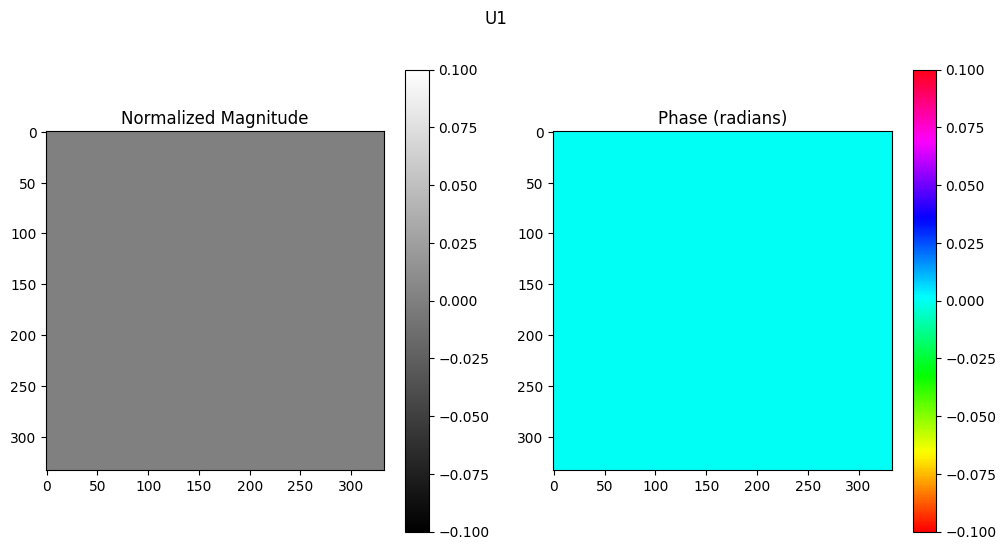

In [44]:
# Create a complex field with magnitude 1 and phase 0
U0 = 1
magnitude = U0*torch.ones_like(xx)
phase = torch.zeros_like(xx)
real_part = magnitude * torch.cos(phase)
imaginary_part = magnitude * torch.sin(phase)
U1 = torch.complex(real_part, imaginary_part)

plot_complex_tensor(U1, 'U1')

Field after circular lens - U2

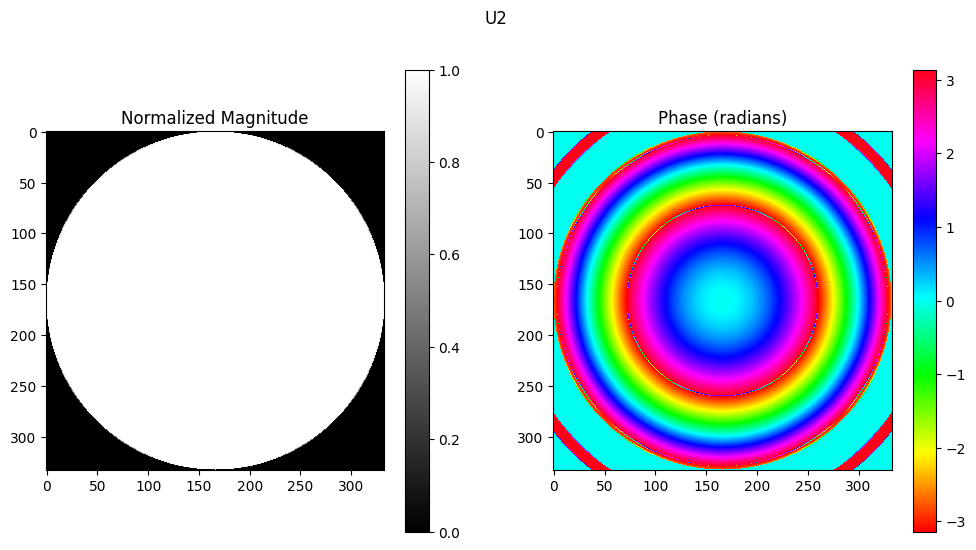

In [45]:
lambda_ = 532/1000
k = 2*torch.pi/lambda_
a = spanX/2
f = a

U2 = transmittance(U1, rr, a, k ,f)
plot_complex_tensor(U2, "U2")

Field at focal plane - U3

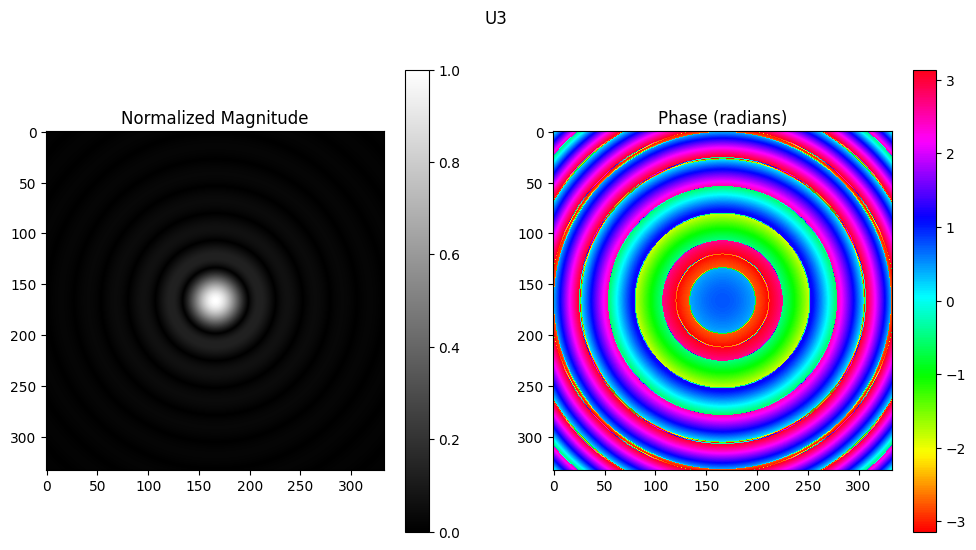

In [46]:
U3 = propogate_to_f(rr, a, f, lambda_, k)
plot_complex_tensor(U3, "U3")

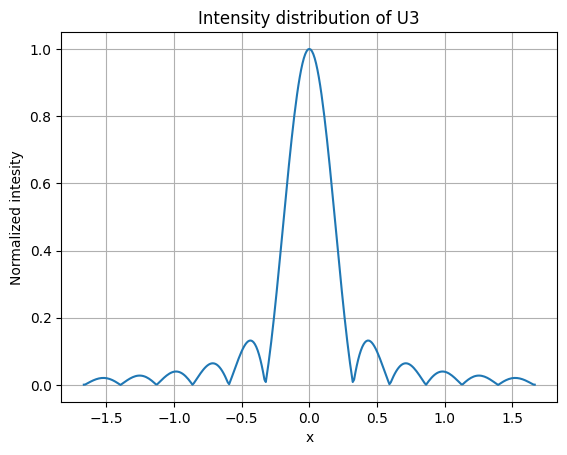

In [47]:
I = torch.abs(U3[Nx//2])
I = (I - I.min()) / (I.max() - I.min() + 1e-08)

plt.plot(xx[0].numpy(), I.numpy())
plt.title('Intensity distribution of U3')
plt.xlabel('x')
plt.ylabel('Normalized intesity')
plt.grid(True)
plt.show()